In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams

In [2]:
IS_GAP = False

In [28]:
notebook_home = os.path.abspath('')
stat_results = os.path.join(notebook_home, "stat_results") if IS_GAP else os.path.join(notebook_home, "stat_results_nogap")
lookup_results = os.path.join(notebook_home, "lookup_results") if IS_GAP else os.path.join(notebook_home, "lookup_results_nogap")
modify_results = os.path.join(notebook_home, "modify_results") if IS_GAP else os.path.join(notebook_home, "modify_results_nogap")
enron_stat, github_stat = os.path.join(stat_results, "enron", "output"), os.path.join(stat_results, "github", "output")
enron_lookup, github_lookup = os.path.join(lookup_results, "enron", "output"), os.path.join(lookup_results, "github", "output")
enron_modify, github_modify = os.path.join(modify_results, "enron", "output"), os.path.join(modify_results, "github", "output")

In [11]:
GRAPH_COLOR = cm.YlGnBu
color_dict = {
    "TACO": GRAPH_COLOR(90),
    "NoComp": GRAPH_COLOR(190)
}
rcParams['font.family'] = 'Serif'
legend_size = 15
label_size = 20
tick_size = 20
fig_width = 8
fig_height = 5

In [12]:
def get_pdf_df(df, column_name, is_log=True):
    ls = [x for x in df[column_name] if x > 10]
    length = len(ls)
    if is_log:
        data = pd.Series(np.log10(ls))
    else:
        data = pd.Series(ls)
    freq = data.value_counts().sort_index(axis=0, ascending=True).reset_index() 
    freq[0] = freq[0] / length
    freq['cumsum'] = np.cumsum(freq[0])
    return freq

In [13]:
def convert_upper_str(num):
    upper_ls = '⁰¹²³⁴⁵⁶⁷⁸⁹'
    index = int(np.log10(num))
    return str(10) + upper_ls[int(np.log10(num))]

In [14]:
def plot_percentile(df_ls, 
                    legend_ls, 
                    xlabel, 
                    ylabel, 
                    x_tick_min,
                    x_tick_max,
                    x_tick_num,
                    fig_size=(fig_width, fig_height),
                    legend_size=legend_size,
                    tick_size=tick_size,
                    label_size=label_size,
                    color_dict=color_dict,
                    save_path=None):
    assert len(df_ls) == len(legend_ls)
    fig, ax = plt.subplots(figsize=fig_size)
    for i in range(len(df_ls)):
        df, label = df_ls[i], legend_ls[i]
        ax.plot(df['index'], df['cumsum'], label=label, color=color_dict[label])
    
    ax.set_xlabel(xlabel, fontsize=label_size)
    ax.set_ylabel(ylabel, fontsize=label_size)
    x_ticks = np.arange(x_tick_min, x_tick_max+0.1, step=(x_tick_max - x_tick_min)/x_tick_num).astype(int)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([convert_upper_str(10**x) for x in x_ticks], fontsize=tick_size)
    ax.legend(fontsize=legend_size)
    fig.tight_layout()
    
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

# 1. Compressed Formula Graph Sizes

In [18]:
def graph_compare_preprocess(df, is_inrow=False):
    df['Edges_Diff'] = df['numEdges'] - df['numCompEdges']
    df['Edges_Prec'] = df['numCompEdges'] / df['numEdges']
    if not is_inrow and IS_GAP:
        pattern_type = ['RR', 'RF', 'FR', 'FF', 'RR-Chain', 'RRGap']
        for pattern in pattern_type:
            if pattern != 'RRGap':
                df[pattern + "_Diff"] = df[pattern + "_NoComp"] - df[pattern + "_Comp"]
            else:
                df[pattern + "_Diff"] = 0
                gaps = ['One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven']
                for gap in gaps:
                    pattern_name = pattern + gap
                    df[pattern + "_Diff"] += (df[pattern_name + "_NoComp"] - df[pattern_name + "_Comp"])
    return df

In [19]:
df_enron_stat = graph_compare_preprocess(pd.read_csv(enron_stat + "/" + "enron_taco_dollar_stat.csv"))
df_github_stat = graph_compare_preprocess(pd.read_csv(github_stat + "/" + "github_taco_dollar_stat.csv"))
#df_enron_inrow_stat = graph_compare_preprocess(pd.read_csv(enron_stat + "/" + "enron_inrow_taco_stat_10k.csv"), True)
#df_github_inrow_stat = graph_compare_preprocess(pd.read_csv(github_stat + "/" + "github_inrow_taco_stat_10k.csv"), True)

In [22]:
df_enron_stat.head()

,fileName,numFormulae,numVertices,numEdges,numCompVertices,numCompEdges,graphBuildTime,Edges_Diff,Edges_Prec
0,chris_germany_000_1_2.pst.1111.xls,8270,27200,26350,11904,11532,1776,14818,0.437647
1,chris_germany_000_1_2.pst.1136.xls,1707,54464,52762,23823,23069,2162,29693,0.437228
2,kevin_ruscitti_000_1_1.pst.100.xls,8268,27200,26350,11904,11532,1132,14818,0.437647
3,kevin_ruscitti_000_1_1.pst.101.xls,8268,27200,26350,11904,11532,1038,14818,0.437647
4,kevin_ruscitti_000_1_1.pst.152.xls,12398,27200,26350,11904,11532,1141,14818,0.437647


## 1.1 Formula graph sizes after TACO compression (low is better)

In [8]:
df_graph_enron_compare = pd.DataFrame()
df_graph_enron_compare.index = ['NoComp', 'TACO-Inrow', 'TACO']
df_graph_enron_compare['Vertices'] = [df_enron_stat['numVertices'].sum(), df_enron_inrow_stat['numCompVertices'].sum(), df_enron_stat['numCompVertices'].sum()]
df_graph_enron_compare['Edges'] = [df_enron_stat['numEdges'].sum(), df_enron_inrow_stat['numCompEdges'].sum(), df_enron_stat['numCompEdges'].sum()]
df_graph_enron_compare['Vertices_Percentage'] = df_graph_enron_compare['Vertices'] / df_graph_enron_compare['Vertices'].max()
df_graph_enron_compare['Edges_Percentage'] = df_graph_enron_compare['Edges'] / df_graph_enron_compare['Edges'].max()
df_graph_enron_compare

,Vertices,Edges,Vertices_Percentage,Edges_Percentage
NoComp,18467065,27083750,1.000000,1.000000
TACO-Inrow,7501502,14077044,0.406210,0.519760
TACO,1315183,1210209,0.071218,0.044684


In [9]:
df_graph_github_compare = pd.DataFrame()
df_graph_github_compare.index = ['NoComp', 'TACO-Inrow', 'TACO']
df_graph_github_compare['Vertices'] = [df_github_stat['numVertices'].sum(), df_github_inrow_stat['numCompVertices'].sum(), df_github_stat['numCompVertices'].sum()]
df_graph_github_compare['Edges'] = [df_github_stat['numEdges'].sum(), df_github_inrow_stat['numCompVertices'].sum(), df_github_stat['numCompEdges'].sum()]
df_graph_github_compare['Vertices_Percentage'] = df_graph_github_compare['Vertices'] / df_graph_github_compare['Vertices'].max()
df_graph_github_compare['Edges_Percentage'] = df_graph_github_compare['Edges'] / df_graph_github_compare['Edges'].max()
df_graph_github_compare

,Vertices,Edges,Vertices_Percentage,Edges_Percentage
NoComp,160240056,216050038,1.000000,1.000000
TACO-Inrow,45453962,45453962,0.283662,0.210386
TACO,3524109,2884193,0.021993,0.013350


## 1.2 The number of edges reduced by TACO (high is better)

In [10]:
df_enron_edge_reduce = pd.DataFrame()
df_enron_edge_reduce['TACO-Inrow'] = df_enron_inrow_stat['Edges_Diff']
df_enron_edge_reduce['TACO'] = df_enron_stat['Edges_Diff']
df_enron_edge_reduce.describe().T[['max', '75%', '50%', 'mean']]

,max,75%,50%,mean
TACO-Inrow,383012.0,22108.0,15003.0,21933.736931
TACO,573599.0,43203.0,20417.0,43631.603710


In [11]:
df_github_edge_reduce = pd.DataFrame()
df_github_edge_reduce['TACO-Inrow'] = df_github_inrow_stat['Edges_Diff']
df_github_edge_reduce['TACO'] = df_github_stat['Edges_Diff']
df_github_edge_reduce.describe().T[['max', '75%', '50%', 'mean']]

,max,75%,50%,mean
TACO-Inrow,2193476.0,53279.5,22758.0,58334.711002
TACO,2455807.0,91166.5,42150.0,105404.228243


## 1.3 Remaining edge fractions after compression (low is better)

In [12]:
df_enron_edge_prec = pd.DataFrame()
df_enron_edge_prec['TACO-Inrow'] = df_enron_inrow_stat['Edges_Prec']
df_enron_edge_prec['TACO'] = df_enron_stat['Edges_Prec']
df_enron_edge_prec.describe().T[['min', '25%', '50%', 'mean']]

,min,25%,50%,mean
TACO-Inrow,0.00001,0.050397,0.377372,0.420695
TACO,0.00001,0.003395,0.013835,0.069730


In [13]:
df_github_edge_prec = pd.DataFrame()
df_github_edge_prec['TACO-Inrow'] = df_github_inrow_stat['Edges_Prec']
df_github_edge_prec['TACO'] = df_github_stat['Edges_Prec']
df_github_edge_prec.describe().T[['min', '25%', '50%', 'mean']]

,min,25%,50%,mean
TACO-Inrow,0.000005,0.000911,0.135342,0.358910
TACO,0.000002,0.000388,0.002020,0.025021


## 1.4 Number of edges reduced by each pattern (high is better)

In [14]:
df_enron_pattern_reduce = pd.DataFrame()
pattern_type = ['RR', 'RF', 'FR', 'FF', 'RR-Chain', 'RRGap']
for pattern in pattern_type:
    df_enron_pattern_reduce[pattern] = df_enron_stat[pattern + "_Diff"]
df_enron_pattern_stat = pd.DataFrame()
df_enron_pattern_stat.index = df_enron_pattern_reduce.T.index
df_enron_pattern_stat['Sum'] = df_enron_pattern_reduce.sum()
df_enron_pattern_stat['Max'] = df_enron_pattern_reduce.max()
df_enron_pattern_stat

,Sum,Max
RR,16316157,258333
RF,1879,1413
FR,149775,13815
FF,3657207,170510
RR-Chain,450504,24596
RRGap,689711,48670


In [15]:
df_github_pattern_reduce = pd.DataFrame()
pattern_type = ['RR', 'RF', 'FR', 'FF', 'RR-Chain', 'RRGap']
for pattern in pattern_type:
    df_github_pattern_reduce[pattern] = df_github_stat[pattern + "_Diff"]
df_github_pattern_stat = pd.DataFrame()
df_github_pattern_stat.index = df_github_pattern_reduce.T.index
df_github_pattern_stat['Sum'] = df_github_pattern_reduce.sum()
df_github_pattern_stat['Max'] = df_github_pattern_reduce.max()
df_github_pattern_stat

,Sum,Max
RR,135900672,1754081
RF,13357,9999
FR,178259,39008
FF,22244085,736581
RR-Chain,5777668,399996
RRGap,1424659,572425


# 2. Building Graphs

In [29]:
column_list = ['fileName', 'GraphBuildTime']
df_enron_taco_max = pd.read_csv(f"{enron_lookup}/enron_max_taco_10k_1.csv")[column_list]
df_enron_taco_long = pd.read_csv(f"{enron_lookup}/enron_long_taco_10k_1.csv")[column_list]
df_enron_nocomp_max = pd.read_csv(f"{enron_lookup}/enron_max_nocomp_10k_1.csv")[column_list]
df_enron_nocomp_long = pd.read_csv(f"{enron_lookup}/enron_long_nocomp_10k_1.csv")[column_list]
df_github_taco_max =  pd.read_csv(f"{github_lookup}/github_max_taco_10k_1.csv")[column_list]
df_github_taco_long = pd.read_csv(f"{github_lookup}/github_long_taco_10k_1.csv")[column_list]
df_github_nocomp_max = pd.read_csv(f"{github_lookup}/github_max_nocomp_10k_1.csv")[column_list]
df_github_nocomp_long = pd.read_csv(f"{github_lookup}/github_long_nocomp_10k_1.csv")[column_list]

In [30]:
df_enron_taco = pd.merge(df_enron_taco_max, df_enron_taco_long, how="inner", on=["fileName"])
df_enron_nocomp = pd.merge(df_enron_nocomp_max, df_enron_nocomp_long, how="inner", on=["fileName"])
df_enron_taco['TACO_GraphBuildTime'] = (df_enron_taco['GraphBuildTime_x'] + df_enron_taco['GraphBuildTime_y']) / 2.
df_enron_nocomp['NoComp_GraphBuildTime'] = (df_enron_nocomp['GraphBuildTime_x'] + df_enron_nocomp['GraphBuildTime_y']) / 2.

In [31]:
enron_graph_result = pd.merge(df_enron_taco, df_enron_nocomp, how="inner", on=['fileName'])[['fileName', 'TACO_GraphBuildTime', 'NoComp_GraphBuildTime']]

In [32]:
enron_graph_result.head()

,fileName,TACO_GraphBuildTime,NoComp_GraphBuildTime
0,stacey_white_000_1_1.pst.254.xls,1754.5,981.0
1,darron_c_giron_002_1_1_1.pst.177.xls,650.0,263.0
2,stacey_white_000_1_1.pst.262.xls,3257.0,1883.0
3,mike_grigsby_000_1_1_1.pst.248.xls,150.0,157.5
4,kevin_ruscitti_000_1_1.pst.156.xls,1123.5,218.0


In [33]:
enron_graph_result['TACO_GraphBuildTime'].mean(), enron_graph_result['NoComp_GraphBuildTime'].mean()

(793.4543918918919, 315.1722972972973)

In [34]:
enron_graph_result.sort_values(by="TACO_GraphBuildTime", ascending=False)

,fileName,TACO_GraphBuildTime,NoComp_GraphBuildTime
280,vkaminski_001_1_2_1.pst.62.xls,13329.0,1544.0
220,mark_haedicke_000_1_2.pst.31.xls,5973.0,1659.5
151,gstorey_000_1_1.pst.116.xls,5715.5,2368.0
38,john_lavorato_000_1_1_1.pst.57.xls,5485.5,1695.5
126,phillip_m_love_000_1_1.pst.476.xls,5211.5,1543.5
...,...,...,...
131,richard_shapiro_001_1_2.pst.124.xls,68.5,69.5
298,cooper_richey_000_1_1.pst.30.xls,62.0,66.0
53,john_zufferli_000_1_1.pst.54.xls,61.5,61.5
249,joe_stepenovitch_000_1_1.pst.15.xls,36.0,37.0


In [36]:
freq_enron_taco = get_pdf_df(enron_graph_result, 'TACO_GraphBuildTime')
freq_enron_nocomp = get_pdf_df(enron_graph_result, 'NoComp_GraphBuildTime')

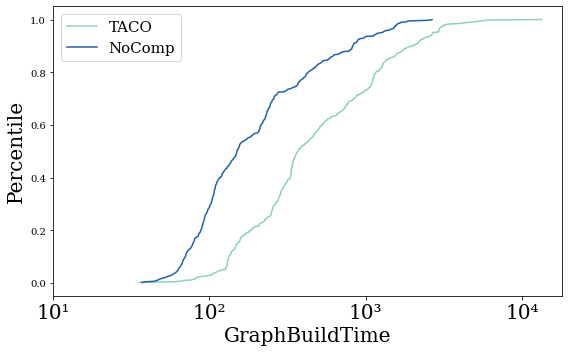

In [39]:
plot_percentile([freq_enron_taco, freq_enron_nocomp], 
                ["TACO", "NoComp"],
                xlabel="GraphBuildTime",
                ylabel="Percentile",
                x_tick_min=1,
                x_tick_max=4,
                x_tick_num=3
               )

In [40]:
df_github_taco = pd.merge(df_github_taco_max, df_github_taco_long, how="inner", on=["fileName"])
df_github_nocomp = pd.merge(df_github_nocomp_max, df_github_nocomp_long, how="inner", on=["fileName"])
df_github_taco['TACO_GraphBuildTime'] = (df_github_taco['GraphBuildTime_x'] + df_github_taco['GraphBuildTime_y']) / 2.
df_github_nocomp['NoComp_GraphBuildTime'] = (df_github_nocomp['GraphBuildTime_x'] + df_github_nocomp['GraphBuildTime_y']) / 2.

In [41]:
github_graph_result = pd.merge(df_github_taco, df_github_nocomp, how="inner", on=['fileName'])[['fileName', 'TACO_GraphBuildTime', 'NoComp_GraphBuildTime']]

In [46]:
github_graph_result['TACO_GraphBuildTime'].mean(), github_graph_result['NoComp_GraphBuildTime'].mean()

(1450.3174709562109, 827.2459785522789)

In [47]:
github_graph_result.sort_values(by="TACO_GraphBuildTime", ascending=False)

,fileName,TACO_GraphBuildTime,NoComp_GraphBuildTime
685,BBG_Security_Application_User_List_v5_46.xlsx,85978.5,41261.5
1643,Master-Calculations-Global-WASH-CBA_GLOBAL_PUB...,70217.5,25956.0
1847,DINAS PENDIDIKAN GABUNG BOS OK BANGET.xlsx,69836.0,24380.0
502,BBG_Security_Application_User_List_v5_34.xlsx,59080.5,27391.5
1431,monte.xlsx,52977.5,1614.5
...,...,...,...
1405,eCwEItsHZq6n07bp1B7JRR4nqHLhroEVLzef5SMlmRwQvw...,31.0,24.0
579,maoyanMovies.xlsx,30.5,34.5
2020,DLT.xlsx,26.0,22.5
719,925_listener_data.xlsx,22.0,28.0


In [48]:
freq_github_taco = get_pdf_df(github_graph_result, 'TACO_GraphBuildTime')
freq_github_nocomp = get_pdf_df(github_graph_result, 'NoComp_GraphBuildTime')

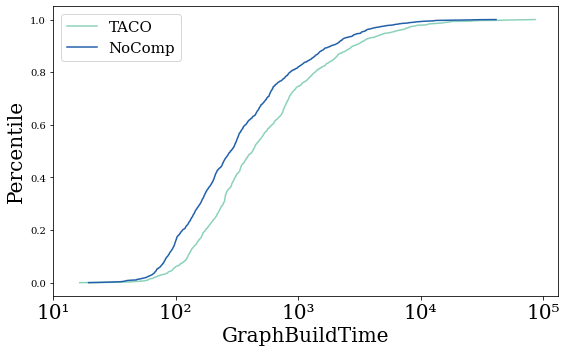

In [50]:
plot_percentile([freq_github_taco, freq_github_nocomp], 
                ["TACO", "NoComp"],
                xlabel="GraphBuildTime",
                ylabel="Percentile",
                x_tick_min=1,
                x_tick_max=5,
                x_tick_num=4
               )

# 3. Returning Control to Users

In [51]:
def rename_columns(df, is_long=False):
    rename_map = {
        "TACOLookupSize": "taco_size",
        "TACOLookupTime": "taco_time",
        "TACOPostProcessedLookupSize": "taco_post_size",
        "TACOPostProcessedLookupTime": "taco_post_time",
        "NoCompLookupSize": "nocomp_size",
        "NoCompLookupTime": "nocomp_time",
        "NoCompPostProcessedLookupSize": "nocomp_post_size",
        "NoCompPostProcessedLookupTime": "nocomp_post_time",
    }
    
    if is_long:
        for key in rename_map:
            rename_map[key] = "long_" + rename_map[key]
    else:
        for key in rename_map:
            rename_map[key] = "max_" + rename_map[key]
            
    df = df.rename(columns=rename_map)
    if "GraphBuildTime" in list(df.columns):
        df = df.drop(['GraphBuildTime'], axis=1)
    
    remain_cols = [x for x in list(df.columns) if "post" not in x]
    return df[remain_cols]

In [53]:
def read_and_average_files(dir_path, fileName, is_long=False):
    df = rename_columns(pd.read_csv(dir_path + "/" + fileName + "_1.csv"), is_long)
    df2 = rename_columns(pd.read_csv(dir_path + "/" + fileName + "_2.csv"), is_long)
    df3 = rename_columns(pd.read_csv(dir_path + "/" + fileName + "_3.csv"), is_long)
    column_list = list(df.columns)
    df_merged = pd.merge(df, df2, how="inner", on=[column_list[0], column_list[1]])
    df_merged = pd.merge(df_merged, df3, how="inner", on=[column_list[0], column_list[1]])
    list1, list2 = [], []
    for i in range(len(df_merged)):
        ls = [df_merged.loc[i, col_name] for col_name in list(df_merged.columns) if column_list[2] in col_name]
        ls2 = [df_merged.loc[i, col_name] for col_name in list(df_merged.columns) if column_list[3] in col_name]
        list1.append(np.mean(ls))
        list2.append(np.mean(ls2))
    df_merged[column_list[2]] = list1
    df_merged[column_list[3]] = list2
    return df_merged[column_list]

In [55]:
df_enron_taco_max = read_and_average_files(enron_lookup, "enron_max_taco_10k", False)
df_enron_taco_long = read_and_average_files(enron_lookup, "enron_long_taco_10k", True)
df_enron_nocomp_max = read_and_average_files(enron_lookup, "enron_max_nocomp_10k", False)
df_enron_nocomp_long = read_and_average_files(enron_lookup, "enron_long_nocomp_10k", True)
df_github_taco_max = read_and_average_files(github_lookup, "github_max_taco_10k", False)
df_github_taco_long = read_and_average_files(github_lookup, "github_long_taco_10k", True)
df_github_nocomp_max = read_and_average_files(github_lookup, "github_max_nocomp_10k", False)
df_github_nocomp_long = read_and_average_files(github_lookup, "github_long_nocomp_10k", True)

In [56]:
df_github_nocomp_long.head()

,fileName,Longest Dep Ref,long_nocomp_size,long_nocomp_time
0,1. Excel Homework.xlsx,Sheet1:J3248,1.0,25.000000
1,2019-05-23-0936_empty_racir.xlsx,Measurements:C11,5610.0,207.666667
2,NIRISS_SIAF.xlsx,DDC:C20,22.0,0.666667
3,工作簿1-20181122170204822.xlsx,不良明细:CEA5,2.0,0.000000
4,W22704-181.xlsx,Sheet1:D2,14196.0,233.666667


In [57]:
df_enron_max = pd.merge(df_enron_taco_max, df_enron_nocomp_max, how="inner", on=["fileName", "Max Dep Ref"])
df_enron_long = pd.merge(df_enron_taco_long, df_enron_nocomp_long, how="inner", on=["fileName", "Longest Dep Ref"])

In [58]:
df_enron_merged = pd.merge(df_enron_max, df_enron_long, how="inner", on=["fileName"])
# df_enron_merged.to_csv("./enron_result_merged.csv", index=False)

In [59]:
df_enron_merged.head()

,fileName,Max Dep Ref,max_taco_size,max_taco_time,max_nocomp_size,max_nocomp_time,Longest Dep Ref,long_taco_size,long_taco_time,long_nocomp_size,long_nocomp_time
0,stacey_white_000_1_1.pst.254.xls,AlphaSort:F6836,3.0,9.333333,3.0,26.000000,AlphaSort:F4400,3.0,9.000000,3.0,26.000000
1,darron_c_giron_002_1_1_1.pst.177.xls,Darron:E5,205.0,8.333333,2978.0,157.333333,Darron:J4,205.0,8.000000,2978.0,144.000000
2,stacey_white_000_1_1.pst.262.xls,BRA Power:A6,28.0,1.000000,4385.0,495.000000,BRA Power:A6,28.0,0.333333,4385.0,478.000000
3,mike_grigsby_000_1_1_1.pst.248.xls,Months:F4,4.0,0.000000,306.0,2.666667,Months:F4,4.0,0.000000,306.0,3.333333
4,kevin_ruscitti_000_1_1.pst.156.xls,03-21-00AM:BT499,0.0,0.000000,0.0,0.000000,03-21-00AM:X531,1.0,0.000000,1.0,0.000000


In [60]:
df_github_max = pd.merge(df_github_taco_max, df_github_nocomp_max, how="inner", on=["fileName", "Max Dep Ref"])
df_github_long = pd.merge(df_github_taco_long, df_github_nocomp_long, how="inner", on=["fileName", "Longest Dep Ref"])

In [61]:
df_github_merged = pd.merge(df_github_max, df_github_long, how="inner", on=["fileName"])
# df_github_merged.to_csv("./github_result_merged.csv", index=False)

In [62]:
df_github_merged.head()

,fileName,Max Dep Ref,max_taco_size,max_taco_time,max_nocomp_size,max_nocomp_time,Longest Dep Ref,long_taco_size,long_taco_time,long_nocomp_size,long_nocomp_time
0,1. Excel Homework.xlsx,Sheet1:E4030,2.0,9.666667,2.0,26.000000,Sheet1:J3248,1.0,8.666667,1.0,25.000000
1,2019-05-23-0936_empty_racir.xlsx,Measurements:E13,20.0,2.000000,6600.0,285.666667,Measurements:C11,17.0,1.333333,5610.0,207.666667
2,NIRISS_SIAF.xlsx,Calc:AE3,23.0,1.000000,690.0,13.000000,DDC:C20,6.0,0.666667,22.0,0.666667
3,工作簿1-20181122170204822.xlsx,不良明细:CBJ5,1.0,0.333333,2.0,0.000000,不良明细:CEA5,1.0,0.333333,2.0,0.000000
4,W22704-181.xlsx,Sheet1:E2,4.0,0.333333,14196.0,211.000000,Sheet1:D2,4.0,0.666667,14196.0,233.666667


### CDF Plot

In [63]:
freq_enron_max_taco_size = get_pdf_df(df_enron_merged, 'max_taco_size', True)
freq_enron_max_nocomp_size = get_pdf_df(df_enron_merged, 'max_nocomp_size', True)
freq_enron_max_taco_time = get_pdf_df(df_enron_merged, 'max_taco_time', True)
freq_enron_max_nocomp_time = get_pdf_df(df_enron_merged, 'max_nocomp_time', True)
freq_enron_long_taco_size = get_pdf_df(df_enron_merged, 'long_taco_size', True)
freq_enron_long_nocomp_size = get_pdf_df(df_enron_merged, 'long_nocomp_size', True)
freq_enron_long_taco_time = get_pdf_df(df_enron_merged, 'long_taco_time', True)
freq_enron_long_nocomp_time = get_pdf_df(df_enron_merged, 'long_nocomp_time', True)

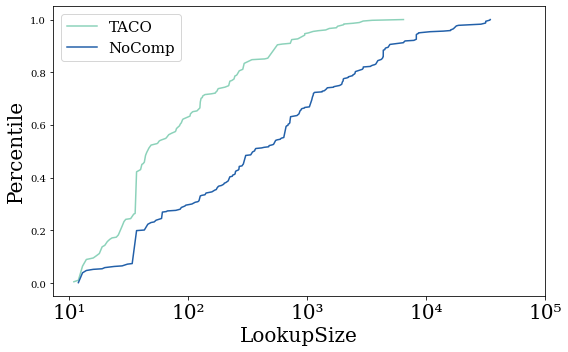

In [64]:
plot_percentile([freq_enron_max_taco_size, freq_enron_max_nocomp_size], 
                ["TACO", "NoComp"],
                xlabel="LookupSize",
                ylabel="Percentile",
                x_tick_min=1,
                x_tick_max=5,
                x_tick_num=4
               )

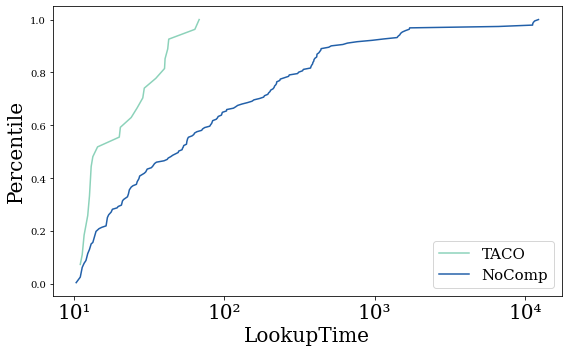

In [65]:
plot_percentile([freq_enron_max_taco_time, freq_enron_max_nocomp_time], 
                ["TACO", "NoComp"],
                xlabel="LookupTime",
                ylabel="Percentile",
                x_tick_min=1,
                x_tick_max=4,
                x_tick_num=3
               )

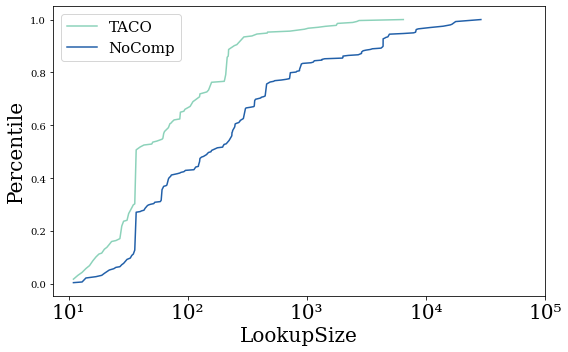

In [68]:
plot_percentile([freq_enron_long_taco_size, freq_enron_long_nocomp_size], 
                ["TACO", "NoComp"],
                xlabel="LookupSize",
                ylabel="Percentile",
                x_tick_min=1,
                x_tick_max=5,
                x_tick_num=4
               )

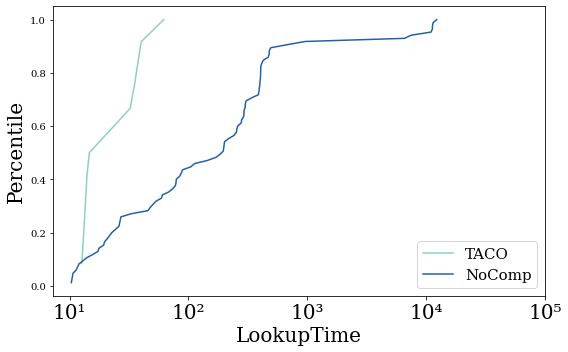

In [70]:
plot_percentile([freq_enron_long_taco_time, freq_enron_long_nocomp_time], 
                ["TACO", "NoComp"],
                xlabel="LookupTime",
                ylabel="Percentile",
                x_tick_min=1,
                x_tick_max=5,
                x_tick_num=4
               )

In [71]:
freq_github_max_taco_size = get_pdf_df(df_github_merged, 'max_taco_size', True)
freq_github_max_nocomp_size = get_pdf_df(df_github_merged, 'max_nocomp_size', True)
freq_github_max_taco_time = get_pdf_df(df_github_merged, 'max_taco_time', True)
freq_github_max_nocomp_time = get_pdf_df(df_github_merged, 'max_nocomp_time', True)
freq_github_long_taco_size = get_pdf_df(df_github_merged, 'long_taco_size', True)
freq_github_long_nocomp_size = get_pdf_df(df_github_merged, 'long_nocomp_size', True)
freq_github_long_taco_time = get_pdf_df(df_github_merged, 'long_taco_time', True)
freq_github_long_nocomp_time = get_pdf_df(df_github_merged, 'long_nocomp_time', True)

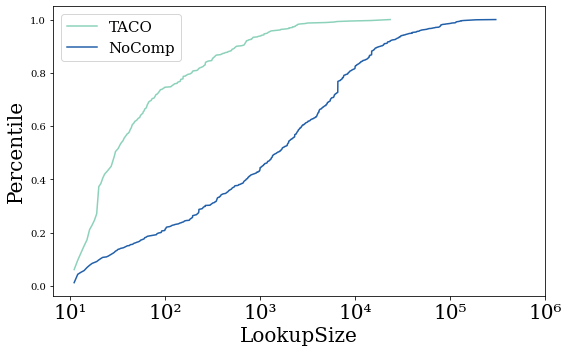

In [73]:
plot_percentile([freq_github_max_taco_size, freq_github_max_nocomp_size], 
                ["TACO", "NoComp"],
                xlabel="LookupSize",
                ylabel="Percentile",
                x_tick_min=1,
                x_tick_max=6,
                x_tick_num=5
               )

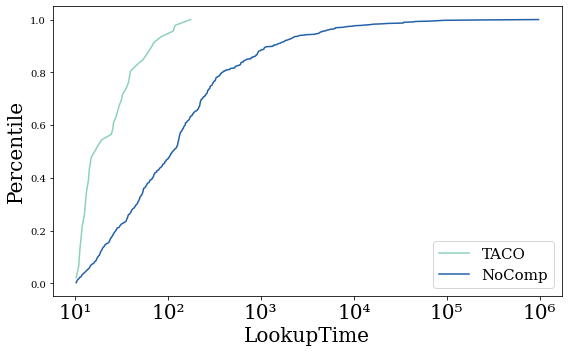

In [74]:
plot_percentile([freq_github_max_taco_time, freq_github_max_nocomp_time], 
                ["TACO", "NoComp"],
                xlabel="LookupTime",
                ylabel="Percentile",
                x_tick_min=1,
                x_tick_max=6,
                x_tick_num=5
               )

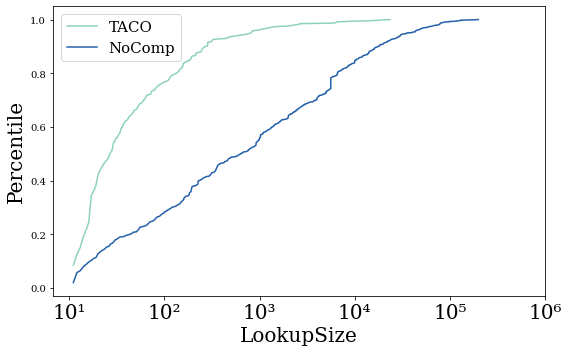

In [76]:
plot_percentile([freq_github_long_taco_size, freq_github_long_nocomp_size], 
                ["TACO", "NoComp"],
                xlabel="LookupSize",
                ylabel="Percentile",
                x_tick_min=1,
                x_tick_max=6,
                x_tick_num=5
               )

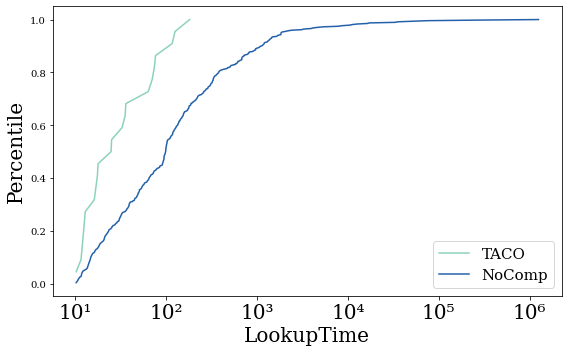

In [77]:
plot_percentile([freq_github_long_taco_time, freq_github_long_nocomp_time], 
                ["TACO", "NoComp"],
                xlabel="LookupTime",
                ylabel="Percentile",
                x_tick_min=1,
                x_tick_max=6,
                x_tick_num=5
               )

### Analyze Enron results

In [78]:
df_enron_merged

,fileName,Max Dep Ref,max_taco_size,max_taco_time,max_nocomp_size,max_nocomp_time,Longest Dep Ref,long_taco_size,long_taco_time,long_nocomp_size,long_nocomp_time
0,stacey_white_000_1_1.pst.254.xls,AlphaSort:F6836,3.0,9.333333,3.0,26.000000,AlphaSort:F4400,3.0,9.000000,3.0,26.000000
1,darron_c_giron_002_1_1_1.pst.177.xls,Darron:E5,205.0,8.333333,2978.0,157.333333,Darron:J4,205.0,8.000000,2978.0,144.000000
2,stacey_white_000_1_1.pst.262.xls,BRA Power:A6,28.0,1.000000,4385.0,495.000000,BRA Power:A6,28.0,0.333333,4385.0,478.000000
3,mike_grigsby_000_1_1_1.pst.248.xls,Months:F4,4.0,0.000000,306.0,2.666667,Months:F4,4.0,0.000000,306.0,3.333333
4,kevin_ruscitti_000_1_1.pst.156.xls,03-21-00AM:BT499,0.0,0.000000,0.0,0.000000,03-21-00AM:X531,1.0,0.000000,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
587,don_baughman_000_1_1.pst.127.xls,Sheet1:C47,37.0,0.333333,37.0,1.000000,Sheet1:C38,37.0,0.000000,37.0,0.000000
588,kevin_ruscitti_000_1_1.pst.4.xls,Swap:A8,29.0,0.333333,1159.0,16.666667,Swap:A8,29.0,0.666667,1159.0,15.666667
589,jane_tholt_000_1_1.pst.198.xls,Summary:B185,57.0,1.000000,1485.0,96.333333,Study 4a:A9,9.0,0.000000,82.0,1.000000
590,andy_zipper_000_1_1.pst.67.xls,DD-ENA:F500,4.0,0.000000,8.0,0.333333,DD-EGL:P29,3.0,0.000000,3.0,0.333333


In [79]:
df_larger_than = df_enron_merged[(df_enron_merged["max_taco_time"] > df_enron_merged["max_nocomp_time"]) & (df_enron_merged["max_nocomp_time"] > 10)]
df_larger_than[["fileName", "max_taco_time", "max_nocomp_time"]]

,fileName,max_taco_time,max_nocomp_time


In [80]:
threshold=500
df_enron_merged[df_enron_merged["max_nocomp_time"] > threshold][["fileName", "max_nocomp_time"]]

,fileName,max_nocomp_time
87,dutch_quigley_000_1_1.pst.51.xls,11267.666667
127,mike_grigsby_000_1_1_1.pst.106.xls,1410.666667
144,matthew_lenhart_000_1_1.pst.23.xls,1711.000000
197,matthew_lenhart_000_1_1.pst.20.xls,1488.666667
220,mark_haedicke_000_1_2.pst.31.xls,1150.000000
267,harry_arora_000_1_1.pst.130.xls,12312.333333
269,matthew_lenhart_000_1_1.pst.1.xls,764.333333
280,vkaminski_001_1_2_1.pst.62.xls,659.333333
290,john_lavorato_001_1_1_1.pst.94.xls,615.000000
301,mike_grigsby_000_1_1_1.pst.108.xls,1700.000000


In [81]:
df_enron_merged[df_enron_merged["long_nocomp_time"] > threshold][["fileName", "long_nocomp_time"]]

,fileName,long_nocomp_time
87,dutch_quigley_000_1_1.pst.51.xls,11465.666667
220,mark_haedicke_000_1_2.pst.31.xls,961.333333
267,harry_arora_000_1_1.pst.130.xls,12297.333333
280,vkaminski_001_1_2_1.pst.62.xls,683.333333
375,jim_schwieger_000_1_1.pst.100.xls,11307.000000
526,john_griffith_000_1_1.pst.185.xls,7498.666667
563,jim_schwieger_000_1_1.pst.71.xls,11325.333333
576,kevin_presto_000_1_1.pst.16.xls,6575.666667
585,jim_schwieger_000_1_1.pst.106.xls,11015.333333


In [82]:
df_enron_merged[df_enron_merged["max_taco_time"] > threshold][["fileName", "max_taco_time"]]

,fileName,max_taco_time


In [83]:
df_enron_merged[df_enron_merged["long_taco_time"] > threshold][["fileName", "long_taco_time"]]

,fileName,long_taco_time


### Analyze github dataset

In [84]:
df_larger_than = df_github_merged[(df_github_merged["max_taco_time"] > df_github_merged["max_nocomp_time"]) & (df_github_merged["max_nocomp_time"] > 10)]
df_larger_than[["fileName", "max_taco_time", "max_nocomp_time"]]

,fileName,max_taco_time,max_nocomp_time


In [85]:
threshold=500
df_github_merged[df_github_merged["max_nocomp_time"] > threshold][["fileName", "max_nocomp_time"]]

,fileName,max_nocomp_time
10,Fact2Sheet_Corona_20200607.xlsx,5079.000000
53,aws-messages-uc-001.xlsx,612.666667
59,地方政府债券整理-hs.xlsx,689.000000
65,Kraken_BTCEUR_1h.xlsx,610.000000
90,crime_v3.xlsx,912.333333
...,...,...
2183,经济总表.xlsx,44456.333333
2199,최경묵_퍼셉트론엑셀.xlsx,1618.000000
2229,aero_test.xlsx,1463.666667
2232,Ventas 2.0 exceldiario.xlsx,2211.000000


In [86]:
df_github_merged[df_github_merged["long_nocomp_time"] > threshold][["fileName", "long_nocomp_time"]]

,fileName,long_nocomp_time
59,地方政府债券整理-hs.xlsx,6.913333e+02
65,Kraken_BTCEUR_1h.xlsx,6.030000e+02
90,crime_v3.xlsx,9.223333e+02
131,DMD_PRJ.xlsx,1.377667e+03
152,gaslines_model_public.xlsx,1.248690e+06
...,...,...
2153,Office Energy Usage_Workbook.xlsx,5.053333e+02
2163,homework7_ducharme_h.xlsx,6.913333e+02
2199,최경묵_퍼셉트론엑셀.xlsx,1.653333e+03
2229,aero_test.xlsx,1.458333e+03


In [87]:
df_github_merged[df_github_merged["max_taco_time"] > threshold][["fileName", "max_taco_time"]]

,fileName,max_taco_time


In [88]:
df_github_merged[df_github_merged["long_taco_time"] > threshold][["fileName", "long_taco_time"]]

,fileName,long_taco_time


# 4. Modify Formula Graph

In [95]:
def load_modify_results(path, filename):
    filename_list = [filename + "_" + str(i) + ".csv" for i in [1, 2, 3]]
    column_list = ['fileName', 'Max Dep Ref', 'GraphModifyTime']
    df1 = pd.read_csv(path + "/" + filename_list[0])
    df2 = pd.read_csv(path + "/" + filename_list[1])
    df3 = pd.read_csv(path + "/" + filename_list[2])
    df = pd.merge(df1, df2, on=column_list[:2], how="inner")
    df = pd.merge(df, df3, on=column_list[:2], how="inner")
    
    time_ls = []
    cand_col = [x for x in list(df.columns) if "GraphModifyTime" in x]
    for i in range(len(df)):
        ls = []
        for col in cand_col:
            ls.append(df.loc[i, col])
        time_ls.append(np.mean(ls))
    df['GraphModifyTime'] = time_ls
    return df[column_list]

In [97]:
enron_nocomp_modify = load_modify_results(enron_modify, "enron_nocomp_modify")
enron_taco_modify = load_modify_results(enron_modify, "enron_taco_modify")
github_nocomp_modify = load_modify_results(github_modify, "github_nocomp_modify")
github_taco_modify = load_modify_results(github_modify, "github_taco_modify")

In [103]:
enron_taco_modify['GraphModifyTime'].mean(), enron_nocomp_modify['GraphModifyTime'].mean()

(3.4025900900900887, 2.5146396396396384)

In [105]:
github_taco_modify['GraphModifyTime'].mean(), github_nocomp_modify['GraphModifyTime'].mean()

(2.821268990169796, 4.049448912719683)

In [106]:
enron_taco_modify['GraphModifyTime'].max(), enron_nocomp_modify['GraphModifyTime'].max()

(173.0, 215.66666666666666)

In [107]:
github_taco_modify['GraphModifyTime'].max(), github_nocomp_modify['GraphModifyTime'].max()

(260.0, 2943.3333333333335)

In [108]:
freq_enron_taco_modify = get_pdf_df(enron_taco_modify, 'GraphModifyTime', True)
freq_enron_nocomp_modify = get_pdf_df(enron_nocomp_modify, 'GraphModifyTime', True)

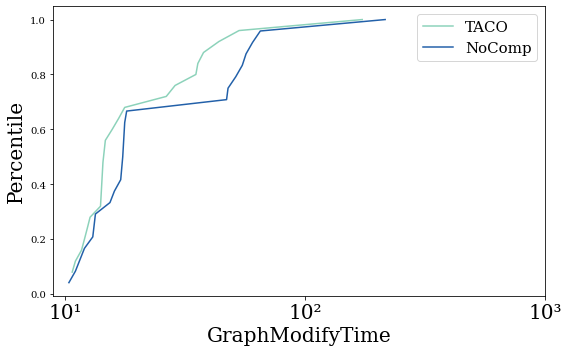

In [111]:
plot_percentile([freq_enron_taco_modify, freq_enron_nocomp_modify], 
                ["TACO", "NoComp"],
                xlabel="GraphModifyTime",
                ylabel="Percentile",
                x_tick_min=1,
                x_tick_max=3,
                x_tick_num=2
               )

In [112]:
freq_github_taco_modify = get_pdf_df(github_taco_modify, 'GraphModifyTime', True)
freq_github_nocomp_modify = get_pdf_df(github_nocomp_modify, 'GraphModifyTime', True)

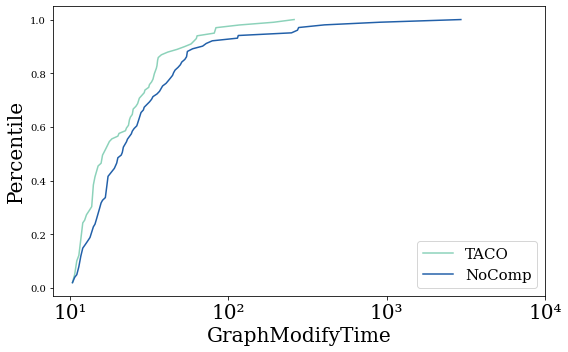

In [116]:
plot_percentile([freq_github_taco_modify, freq_github_nocomp_modify], 
                ["TACO", "NoComp"],
                xlabel="GraphModifyTime",
                ylabel="Percentile",
                x_tick_min=1,
                x_tick_max=4,
                x_tick_num=3
               )